# Word2Vec - Word Embeddings

In [1]:
import sys
import os
import pandas as pd

# Agregar el directorio raiz al PYTHONPATH
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [9]:
# Cargar datos
from constants.constants_tiktok import TIKTOK_DATASET_SENTENCES

df_sentences = pd.read_csv(TIKTOK_DATASET_SENTENCES, encoding="utf-8")
print(df_sentences.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67551 entries, 0 to 67550
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      67551 non-null  object
 1   polarity  67551 non-null  int64 
 2   emotion   67551 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB
None


In [10]:
DIM_EMBEDDINGS = 100
SG = 1
EPOCHS = 50

## Generar embeddings

In [11]:
from src.preprocesamiento.nlp_spacy import Tokenizer

docs = Tokenizer().tokenize(df_sentences['text'], True)

Modelo cargado: es_core_news_sm


100%|██████████| 67551/67551 [00:54<00:00, 1231.45it/s]


In [12]:
# Tokenizar el texto
import gensim
from constants.constants_tiktok import EMBEDDING_W2V_TIKTOK_SENTENCES_PATH

print("Entrenando modelo de W2V...")
model = gensim.models.Word2Vec(
    sentences=docs,
    vector_size=DIM_EMBEDDINGS,
    epochs=EPOCHS,
    seed=42,
    sg=SG # skipgram or cbow
)

# Guardar modelo
model.save(f"{EMBEDDING_W2V_TIKTOK_SENTENCES_PATH}.model")
# Guardar VEctores de palabras (no entrenables)
model.wv.save_word2vec_format(f"{EMBEDDING_W2V_TIKTOK_SENTENCES_PATH}.bin", binary=True)

print(f"Modelo guardado en {EMBEDDING_W2V_TIKTOK_SENTENCES_PATH}.model")
print(f"Word Vectors guardados en {EMBEDDING_W2V_TIKTOK_SENTENCES_PATH}.bin")

Entrenando modelo de W2V...
Modelo guardado en c:\Users\Diego\Desktop\sentiment_analysis\models\tiktok\embeddings\w2v_embeddings_tiktok_sentences.model
Word Vectors guardados en c:\Users\Diego\Desktop\sentiment_analysis\models\tiktok\embeddings\w2v_embeddings_tiktok_sentences.bin


## Test

In [14]:
from src.trainers.utils import EmbeddingLoader
from constants.constants_tiktok import EMBEDDING_W2V_TIKTOK_SENTENCES_PATH

path = f"{EMBEDDING_W2V_TIKTOK_SENTENCES_PATH}.bin"
embedding_loader = EmbeddingLoader(path)
word_vectors = embedding_loader.get_word_vectors()

print(f" Tamaño de embeddings: {word_vectors.vector_size}")
print(f" Tamaño del vocabulario: {len(word_vectors)}")

word_vectors.most_similar("escuel")

 Tamaño de embeddings: 100
 Tamaño del vocabulario: 7059


[('alumn', 0.6414739489555359),
 ('politecn', 0.6322333812713623),
 ('estudi', 0.6240257620811462),
 ('preparatori', 0.5839586853981018),
 ('carrer', 0.5582779049873352),
 ('univers', 0.541727602481842),
 ('facult', 0.5321820378303528),
 ('medicin', 0.5191490054130554),
 ('upe', 0.5188164710998535),
 ('vocacional', 0.5137828588485718)]

In [15]:
word_vectors.most_similar("quimic")

[('biologi', 0.5691139101982117),
 ('ingeni', 0.4993211627006531),
 ('biolog', 0.4805031716823578),
 ('reactor', 0.47357454895973206),
 ('glicin', 0.4670121967792511),
 ('geolog', 0.4655430018901825),
 ('matemat', 0.4572635889053345),
 ('farmaceut', 0.456389844417572),
 ('tropic', 0.4533758759498596),
 ('facult', 0.45303186774253845)]

## ¿Cuanto espacio ocupa en RAM el modelo?

In [16]:
import numpy as np

vocab_size = len(word_vectors.index_to_key)
embedding_dim = word_vectors.vector_size

print(f" Tamaño del vocabulario: {vocab_size}")
print(f" Tamaño de los embeddings: {embedding_dim}")
print(f" Tipo de dato de los embeddings: {word_vectors.vectors.dtype}")

bytes_per_number = np.dtype(np.float32).itemsize  # 4 bytes por número
total_bytes = vocab_size * embedding_dim * bytes_per_number
total_mb = total_bytes / (1024 ** 2)  # Convertir a MB

print(f"El modelo ocupa aproximadamente: {total_mb:.2f} MB en RAM")

 Tamaño del vocabulario: 7059
 Tamaño de los embeddings: 100
 Tipo de dato de los embeddings: float32
El modelo ocupa aproximadamente: 2.69 MB en RAM


## ¿Cuánto espacio ocupan los embeddings de cada token del dataset de TikTok?

In [17]:
total_memory = 0

for doc in docs:
    embeddings = [embedding_loader.get_embedding(token) for token in doc]
    memory_per_text = len(embeddings) * word_vectors.vector_size * 4 / (1024)
    total_memory += memory_per_text

print(f"Memoria total ocupada por los embeddings: {total_memory:.2f} KB -> {total_memory/(1024**2):.2f} GB")


Memoria total ocupada por los embeddings: 203267.19 KB -> 0.19 GB


## Graficar algunos embeddings

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import plotly.express as px
import plotly.io as pio

bg_color="plotly_dark" # https://plotly.com/python/templates/
pio.templates.default = bg_color # Establecer el tema oscuro por defecto

words = list(word_vectors.index_to_key)[:300]
print(words)
embeddings = [embedding_loader.get_embedding(word) for word in words]
embeddings = np.array(embeddings)

pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(embeddings)

df = pd.DataFrame(embeddings_3d, columns=["X", "Y", "Z"])
df["word"] = words

fig = px.scatter_3d(df, x="X", y="Y", z="Z", text="word", title="Visualización 3D de Embeddings", width=800, height=800)
fig.update_traces(marker=dict(size=6), selector=dict(mode='markers+text'))
fig.show()

['el', 'ver', 'pon', 'pod', 'ten', 'dec', 'pas', 'quer', 'cos', 'gust', 'estudi', 'person', 'mexic', 'año', 'telefon', 'pelicul', 'vide', 'sal', 'estar', 'cas', 'dej', 'gent', 'habl', 'trabaj', 'san', 'compr', 'lleg', 'ven', 'cam', 'carrer', 'vid', 'sent', 'pantall', 'tiemp', 'lug', 'dar', 'histori', 'cre', 'car', 'qued', 'tom', 'pes', 'mund', 'mejor', 'import', 'univers', 'empez', 'llam', 'tip', 'problem', 'funcion', 'seri', 'numer', 'cambi', 'viv', 'punt', 'moment', 'ir', 'pens', 'amig', 'pregunt', 'vas', 'mal', '5', 'encontr', 'hac', 'exam', 'mir', 'pais', 'ped', 'muj', 'conoc', 'val', 'segu', 'ejempl', '10', 'deb', 'product', 'marc', 'esper', 'form', 'tem', 'realment', 'libr', 'bat', '2', 'preci', 'hab', 'segur', 'termin', 'gan', 'pag', 'hombr', 'man', 'proces', 'aplic', 'gener', 'gal', 'vist', 'opcion', 'va', 'hor', 'unic', 'comentari', 'busc', '3', 'carg', 'sup', 'explic', 'mexican', 'ayud', 'cost', 'equip', 'necesit', 'entrar', 'complet', 'ion', 'pro', 'disposit', 'entend', 'esc

['el', 'ver', 'pon', 'pod', 'ten', 'dec', 'pas', 'quer', 'cos', 'gust', 'estudi', 'person', 'mexic', 'año', 'telefon', 'pelicul', 'vide', 'sal', 'estar', 'cas', 'dej', 'gent', 'habl', 'trabaj', 'san', 'compr', 'lleg', 'ven', 'cam', 'carrer', 'vid', 'sent', 'pantall', 'tiemp', 'lug', 'dar', 'histori', 'cre', 'car', 'qued', 'tom', 'pes', 'mund', 'mejor', 'import', 'univers', 'empez', 'llam', 'tip', 'problem', 'funcion', 'seri', 'numer', 'cambi', 'viv', 'punt', 'moment', 'ir', 'pens', 'amig', 'pregunt', 'vas', 'mal', '5', 'encontr', 'hac', 'exam', 'mir', 'pais', 'ped', 'muj', 'conoc', 'val', 'segu', 'ejempl', '10', 'deb', 'product', 'marc', 'esper', 'form', 'tem', 'realment', 'libr', 'bat', '2', 'preci', 'hab', 'segur', 'termin', 'gan', 'pag', 'hombr', 'man', 'proces', 'aplic', 'gener', 'gal', 'vist', 'opcion', 'va', 'hor', 'unic', 'comentari', 'busc', '3', 'carg', 'sup', 'explic', 'mexican', 'ayud', 'cost', 'equip', 'necesit', 'entrar', 'complet', 'ion', 'pro', 'disposit', 'entend', 'esc

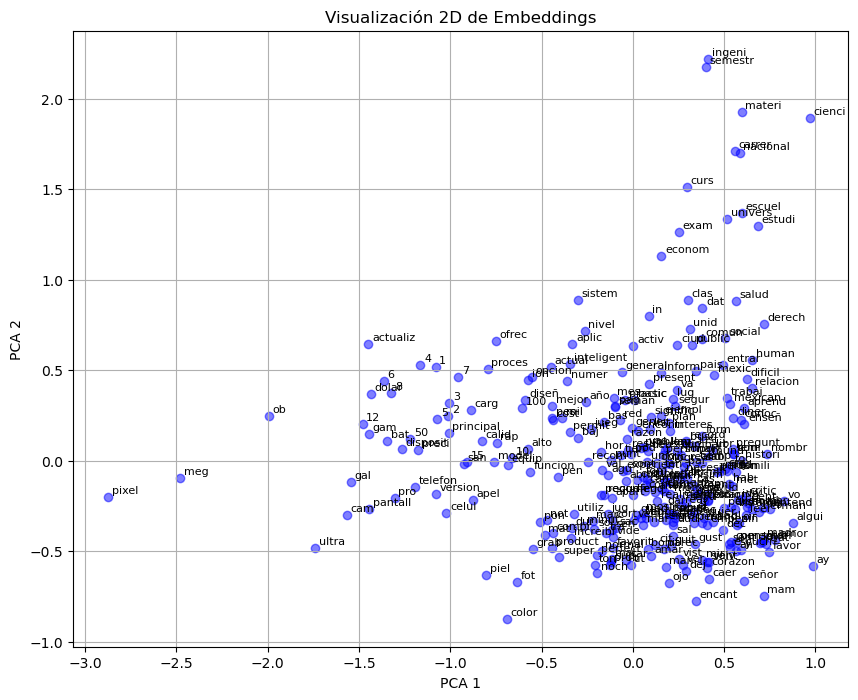

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

words = list(word_vectors.index_to_key)[:300]
print(words)
embeddings = [embedding_loader.get_embedding(word) for word in words]
embeddings = np.array(embeddings)

pca = PCA(n_components=2) # Reducción de embeddings a 2 dimensiones
embeddings_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 8))

for i in range(len(embeddings_2d)):
    x, y_ = embeddings_2d[i]
    plt.scatter(x, y_, color='blue', alpha=0.5)
    plt.text(x + 0.02, y_ + 0.02, str(words[i]), fontsize=8)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Visualización 2D de Embeddings')
plt.grid(True)
plt.show()